# FomulaBEAT

最終版：中置記法を前置記法に変換するタスク

5-3をベースに変更

In [1]:
version = '06-3'
model_dir = './model/' + version
data_path = f'data/eq05-3.txt'
test_data_path = f'data/eq05-3-test.txt'

## 事前定義

In [2]:
# import library
from pathlib import Path
import math
import time
from collections import Counter
from tqdm import tqdm
import torch
from torch.utils.data import random_split
import torch.nn as nn
from torch import Tensor
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import Tensor
import joblib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import umap
import seaborn as sns
import pandas as pd
import japanize_matplotlib

In [3]:
# 事前設定
%load_ext autoreload
%autoreload 2
torch.set_printoptions(linewidth=100)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model_dir_path = Path(model_dir)
if not model_dir_path.exists():
    model_dir_path.mkdir(parents=True)

Using device: cuda:0


データの取得

In [4]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    src_data, tgt_data = [], []
    for line in lines:
        src, tgt = line.strip().split(' => ')
        src_data.append(src)
        tgt_data.append(tgt)
    return src_data, tgt_data


In [5]:
# ファイルを読み込み、数式データを取得
src_data, tgt_data = read_file(data_path)
print(src_data[:3], tgt_data[:3])


['0*1', '1+0*0', '0+1+0*1*1*1+0'] ['*01', '+1*00', '+0+1+*0*1*110']


辞書データの作成

In [6]:
SPECIALS = ['<start>', '<end>', '<pad>', '<unk>']

def build_vocab(texts):
    vocab = {}
    idx = 0
    # 数字の語彙定義
    for i in range(10):
        vocab[str(i)] = idx
        idx += 1
    # その他の文字の語彙定義
    for text in texts:
        for char in text:
            if char not in vocab:
                vocab[char] = idx
                idx += 1
    # 特別語の語彙定義
    for sp in SPECIALS:
        vocab[sp] = idx
        idx += 1
    return vocab


def convert_text_to_indexes(text, vocab):
    # <start> と <end> トークンを追加して数値化
    return [vocab['<start>']] + [vocab[char] if char in vocab else vocab['<unk>'] for char in text] + [vocab['<end>']]

# データを処理して Train と Valid に分ける関数
# データを処理して Train と Valid に分ける関数
def data_process_split(src_texts, tgt_texts, vocab_src, vocab_tgt, valid_size=0.2):
    # データを数値化
    data = []
    for (src, tgt) in zip(src_texts, tgt_texts):
        src_tensor = torch.tensor(convert_text_to_indexes(src, vocab_src), dtype=torch.long)
        tgt_tensor = torch.tensor(convert_text_to_indexes(tgt, vocab_tgt), dtype=torch.long)
        data.append((src_tensor, tgt_tensor))
    
    # データのサイズを計算して、訓練データと検証データに分割
    data_size = len(data)
    valid_size = int(valid_size * data_size)
    train_size = data_size - valid_size

    # PyTorchのrandom_splitを使って分割
    train_data, valid_data = random_split(data, [train_size, valid_size])
    
    return train_data, valid_data



In [7]:
# srcとtgtを結合して辞書を構築
vocab_src = vocab_tgt = build_vocab(src_data + tgt_data)

print(vocab_src)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '*': 10, '+': 11, '<start>': 12, '<end>': 13, '<pad>': 14, '<unk>': 15}


In [8]:
convert_text_to_indexes("01", vocab_src)


[12, 0, 1, 13]

In [9]:

# データを数値化
train_data, valid_data = data_process_split(src_data, tgt_data, vocab_src, vocab_tgt)

# 結果の確認
print('インデックス化された文章')
print(f"Input: {train_data[0][0]}\nOutput: {train_data[0][1]}")

# インデックスから元の文字列に戻す
def convert_indexes_to_text(indexes:list, vocab):
    reverse_vocab = {idx: token for token, idx in vocab.items()}
    return ''.join([reverse_vocab[idx] for idx in indexes if idx in reverse_vocab and reverse_vocab[idx] not in ['<start>', '<end>', '<pad>']])

print('元に戻した文章')
print(f"Input: {convert_indexes_to_text(train_data[0][0].tolist(), vocab_src)}")
print(f"Output: {convert_indexes_to_text(train_data[0][1].tolist(), vocab_tgt)}")


インデックス化された文章
Input: tensor([12,  0, 10,  1, 13])
Output: tensor([12, 10,  0,  1, 13])
元に戻した文章
Input: 0*1
Output: *01


In [10]:
batch_size = 1024
PAD_IDX = vocab_src['<pad>']
START_IDX = vocab_src['<start>']
END_IDX = vocab_src['<end>']

def generate_batch(data_batch):
    
    batch_src, batch_tgt = [], []
    for src, tgt in data_batch:
        batch_src.append(src)
        batch_tgt.append(tgt)
        
    batch_src = pad_sequence(batch_src, padding_value=PAD_IDX)
    batch_tgt = pad_sequence(batch_tgt, padding_value=PAD_IDX)
    
    return batch_src, batch_tgt

train_iter = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)
valid_iter = DataLoader(valid_data, batch_size=batch_size, shuffle=True, collate_fn=generate_batch)

In [11]:
len(train_data)

800000

Transoformerの設定

In [12]:
class TokenEmbedding(nn.Module):
    
    def __init__(self, vocab_size, embedding_size):
        
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=PAD_IDX)
        self.embedding_size = embedding_size
        
    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.embedding_size)
    
    
class PositionalEncoding(nn.Module):
    
    def __init__(self, embedding_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('embedding_pos', embedding_pos)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.embedding_pos[: token_embedding.size(0), :])


In [13]:

class TransformerDecoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerDecoderLayerScratch, self).__init__()
        # Self-attention for the decoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Multihead attention for attending to encoder outputs (memory)
        self.cross_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Layer normalization layers
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)


    def forward(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        # Self-attention
        tgt2, _ = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        
        #Cross-attention
        tgt2, _ = self.cross_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)

        return tgt

class TransformerEncoderLayerScratch(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout=0.1):
        super(TransformerEncoderLayerScratch, self).__init__()
        # Self-attention for the encoder
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        # Self-attention
        memory, _ = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        memory = src + self.dropout1(memory)
        memory = self.norm1(memory)
        
        return memory


In [14]:

class Seq2SeqTransformer(nn.Module):
    
    def __init__(
        self, num_encoder_layers: int, num_decoder_layers: int,
        embedding_size: int, vocab_size: int,
        dim_feedforward:int = 512, dropout:float = 0.1, nhead:int = 8
    ):
        
        super(Seq2SeqTransformer, self).__init__()

        self.token_embedding = TokenEmbedding(vocab_size, embedding_size)
        self.positional_encoding = PositionalEncoding(embedding_size, dropout=dropout)
        self.encoder_layer = TransformerEncoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )

        self.decoder_layer = TransformerDecoderLayerScratch(
            d_model=embedding_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout
        )
        
        # self.output = nn.Linear(embedding_size, vocab_size)

    def forward(
        self, src: Tensor, tgt: Tensor,
        mask_src: Tensor, mask_tgt: Tensor,
        padding_mask_src: Tensor, padding_mask_tgt: Tensor,
        memory_key_padding_mask: Tensor
    ):
        embedding_src = self.positional_encoding(self.token_embedding(src))
        memory = self.encoder_layer(embedding_src, mask_src, padding_mask_src)
        embedding_tgt = self.positional_encoding(self.token_embedding(tgt))
        outs = self.decoder_layer(
            embedding_tgt, memory, mask_tgt, None,
            padding_mask_tgt, memory_key_padding_mask
        )
        return self.compute_output(outs)
    
    def compute_output(self, outs: Tensor):
        # token embeddingの重みを転置して出力層で使用する
        output = torch.matmul(outs/math.sqrt(self.token_embedding.embedding_size), self.token_embedding.embedding.weight.transpose(0, 1))
        return output

    def decode(self, tgt: Tensor, memory: Tensor, mask_tgt: Tensor):
        return self.decoder_layer(self.positional_encoding(self.token_embedding(tgt)), memory, mask_tgt)

In [15]:
def create_mask(src, tgt, PAD_IDX):
    
    seq_len_src = src.shape[0]
    seq_len_tgt = tgt.shape[0]

    mask_src = torch.zeros((seq_len_src, seq_len_src), device=device).type(torch.bool)
    mask_tgt = generate_square_subsequent_mask(seq_len_tgt)

    padding_mask_src = (src == PAD_IDX).transpose(0, 1)
    padding_mask_tgt = (tgt == PAD_IDX).transpose(0, 1)
    
    return mask_src, mask_tgt, padding_mask_src, padding_mask_tgt


def generate_square_subsequent_mask(seq_len):
    mask = (torch.triu(torch.ones((seq_len, seq_len), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

学習の定義

In [16]:
def train(model, data, optimizer, criterion, PAD_IDX):
    
    model.train()
    losses = 0
    for src, tgt in tqdm(data):
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )

        optimizer.zero_grad()
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()
        
    return losses / len(data)

In [17]:

def evaluate(model, data, criterion, PAD_IDX):
    
    model.eval()
    losses = 0
    for src, tgt in data:
        
        src = src.to(device)
        tgt = tgt.to(device)

        input_tgt = tgt[:-1, :]

        mask_src, mask_tgt, padding_mask_src, padding_mask_tgt = create_mask(src, input_tgt, PAD_IDX)

        logits = model(
            src=src, tgt=input_tgt,
            mask_src=mask_src, mask_tgt=mask_tgt,
            padding_mask_src=padding_mask_src, padding_mask_tgt=padding_mask_tgt,
            memory_key_padding_mask=padding_mask_src
        )
        
        output_tgt = tgt[1:, :]
        loss = criterion(logits.reshape(-1, logits.shape[-1]), output_tgt.reshape(-1))
        losses += loss.item()
        
    return losses / len(data)

設定

In [18]:
vocab_size_src = len(vocab_src)
vocab_size_tgt = len(vocab_tgt)
embedding_size = 16
nhead = 1
dim_feedforward = 16
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0
# vocab_size_src = len(vocab_src)
# vocab_size_tgt = len(vocab_tgt)
# embedding_size = 240
# nhead = 8
# dim_feedforward = 100
# num_encoder_layers = 2
# num_decoder_layers = 2
# dropout = 0.1

model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(model.parameters())

モデルの調査

In [19]:
print(model)

Seq2SeqTransformer(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 16, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace

In [20]:
# モデル内の層の名前とパラメータ情報を表示
LP = list(model.named_parameters())
lp = len(LP)
print(f"{lp} 層")
for p in range(0, lp):
    print(f"\n層名: {LP[p][0]}")
    print(f"形状: {LP[p][1].shape}")
    print(f"値: {LP[p][1]}")


19 層

層名: token_embedding.embedding.weight
形状: torch.Size([16, 16])
値: Parameter containing:
tensor([[-0.1842,  0.0225,  0.3177, -0.2948,  0.0399,  0.0226,  0.0114,  0.3450,  0.3975, -0.3764,
         -0.0516,  0.2101,  0.1128, -0.3134, -0.3474,  0.1511],
        [-0.3915, -0.1904,  0.3660,  0.3417,  0.2302, -0.0999, -0.0794,  0.0296,  0.1718, -0.1110,
          0.1388,  0.2473, -0.2887,  0.3772,  0.2709, -0.4252],
        [-0.0885, -0.2137,  0.1308, -0.0429, -0.3278, -0.4324, -0.0207,  0.0633, -0.2241,  0.0483,
         -0.2621, -0.1327,  0.3313, -0.2724,  0.4264, -0.4031],
        [ 0.0867, -0.4166,  0.1254,  0.2843, -0.0581,  0.0855, -0.0407, -0.0500,  0.3267,  0.1126,
         -0.1649,  0.3874,  0.3833,  0.4318, -0.2166, -0.1139],
        [ 0.1520,  0.2734, -0.3244,  0.1903, -0.2069,  0.1393, -0.2690, -0.0093, -0.1264, -0.4150,
          0.3795,  0.2431, -0.0624, -0.2093, -0.1670, -0.2762],
        [-0.0610,  0.0475, -0.1413,  0.1030,  0.0654, -0.0032,  0.0060, -0.2119,  0.0979,  0

## 学習実行

In [ ]:
epoch = 50
best_loss = float('Inf')
best_model = None
patience = 10
counter = 0

# 可視化用に保存
train_losses = []
valid_losses = []

for loop in range(1, epoch + 1):
    
    start_time = time.time()
    
    loss_train = train(
        model=model, data=train_iter, optimizer=optimizer,
        criterion=criterion, PAD_IDX=PAD_IDX
    )
    
    elapsed_time = time.time() - start_time
    
    loss_valid = evaluate(
        model=model, data=valid_iter, criterion=criterion, PAD_IDX=PAD_IDX
    )

    train_losses.append(loss_train)
    valid_losses.append(loss_valid)
    
    print('[{}/{}] train loss: {:.4f}, valid loss: {:.4f}  [{}{:.0f}s] counter: {} {}'.format(
        loop, epoch,
        loss_train, loss_valid,
        str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else '',
        elapsed_time % 60,
        counter,
        '**' if best_loss > loss_valid else ''
    ))
    
    counter += 1
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model
        counter = 0
        
    if counter > patience:
        break
    

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('エポックごとの損失関数の推移(Task3)')
plt.legend()
plt.show()

# plt.savefig(model_dir_path.joinpath(version + '_loss_plot.png'))
# print("Loss plot saved to:", model_dir_path.joinpath(version + '_loss_plot.png'))
# plt.close()

学習したモデルの保存

In [ ]:
torch.save(best_model.state_dict(), model_dir_path.joinpath(version + 'translation_transfomer.pth'))

学習lossの推移を保存

In [ ]:
import pandas as pd

# 保存するデータを作成
loss_data = pd.DataFrame({
    'epoch': list(range(1, len(train_losses) + 1)),
    'train_loss': train_losses,
    'valid_loss': valid_losses
})

# CSVファイルとして保存
loss_file_path = model_dir_path.joinpath(version + '_losses.csv')
loss_data.to_csv(loss_file_path, index=False)
print(f"Loss data saved to {loss_file_path}")


学習したモデルを使って翻訳をする

In [21]:
# モデルのロード
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')
loaded_model = Seq2SeqTransformer(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [22]:
def translate(src_sentence, model=loaded_model, vocab_src=vocab_src, vocab_tgt=vocab_tgt, max_len=50):
    model.eval()
    
    # 数値化されたソース文を生成
    src_indexes = torch.tensor([convert_text_to_indexes(src_sentence, vocab_src)], device=device).transpose(0, 1)

    # 初期ターゲット文に <start> トークンを設定
    tgt_indexes = torch.tensor([START_IDX], device=device).unsqueeze(1)

    memory = model.positional_encoding(model.token_embedding(src_indexes))
    memory = model.encoder_layer(memory)

    for _ in range(max_len):
        # デコード
        output = model.decode(tgt_indexes, memory, generate_square_subsequent_mask(tgt_indexes.size(0)))
        next_token = model.compute_output(output)[-1, :].argmax(1).item()

        # 予測トークンをターゲット文に追加
        tgt_indexes = torch.cat([tgt_indexes, torch.tensor([[next_token]], device=device)], dim=0)

        # <end> トークンで終了
        if next_token == END_IDX:
            break

    # インデックスから文字列に変換
    return convert_indexes_to_text(tgt_indexes.squeeze(1).tolist(), vocab_tgt)

In [23]:
text = "0*1+1+0*0"
translation = translate(text)

print(f"Input: {text}")
print(f"Output: {translation}")

Input: 0*1+1+0*0
Output: +*01+1*00


In [24]:
def read_file(file_path):
    with open(file_path, 'r') as file:
        return [tuple(line.strip().split(' => ')) for line in file.readlines()]

def calculate_test_accuracy(test_data):
    # テストデータの読み込み
    correct, mistakes = 0, []
    num_test_data = len(test_data)
    for i, (src_text, tgt_text) in enumerate(test_data):
        print(f'{i/num_test_data*100:.2f}%', end='\r')
        translation = translate(src_text)
        if translation == tgt_text:
            correct += 1
        else:
            mistakes.append((src_text, translation, tgt_text))
    return correct/num_test_data, mistakes

# 正答率の計算
test_data = read_file(test_data_path)
accuracy, mistakes = calculate_test_accuracy(test_data)

# 正答率の表示
print(f"Test Accuracy: {accuracy:.2f}%")
print(f"Mistakes: {len(mistakes)} out of {len(test_data)}")

# 間違えたケースの一部（10件まで）を表示
print("\nExamples of mistakes:")
for i, (src_text, translation, tgt_text) in enumerate(mistakes[:10]):
    print(f"Input  : {src_text}")
    print(f"Output : {translation}")
    print(f"Correct: {tgt_text}")
    print('---')


Test Accuracy: 1.00%
Mistakes: 0 out of 5000

Examples of mistakes:


## モデルの動作を分析

### 初期設定

#### モデルの設定

In [25]:
model_path = model_dir_path.joinpath(version + 'translation_transfomer.pth')

#loaded_model用のSeq2Seqクラス
class Seq2SeqForSavedModel(Seq2SeqTransformer):
    def __init__(self, *args, **kwargs):
        super(Seq2SeqForSavedModel, self).__init__(*args, **kwargs)
        self.pca = None

    def positional_encoding(self, tensor: Tensor, maxlen=5000):
        embedding_size = tensor.size(-1)
        den = torch.exp(-torch.arange(0, embedding_size, 2) * math.log(10000) / embedding_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        embedding_pos = torch.zeros((maxlen, embedding_size))
        embedding_pos[:, 0::2] = torch.sin(pos * den)
        embedding_pos[:, 1::2] = torch.cos(pos * den)
        embedding_pos = embedding_pos.unsqueeze(-2)
        return tensor + embedding_pos[: tensor.size(0), :].to(tensor.device)
    
    def self_attn_decoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.decoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.decoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.decoder_layer.self_attn.out_proj.weight.data.T) + self.decoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights

    def self_attn_encoder(self, tgt, embedding_size):
        self_attn_wq, self_attn_wk, self_attn_wv = self.encoder_layer.self_attn.in_proj_weight.data.chunk(3, dim=0)
        self_attn_bq, self_attn_bk, self_attn_bv = self.encoder_layer.self_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wq.T) + self_attn_bq
        KW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wk.T) + self_attn_bk
        VW = torch.matmul(tgt.permute(1, 0, 2), self_attn_wv.T) + self_attn_bv
        self_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(self_attn_weights, VW)
        self_attn_output = torch.matmul(AV, self.encoder_layer.self_attn.out_proj.weight.data.T) + self.encoder_layer.self_attn.out_proj.bias.data
        return tgt + self_attn_output.permute(1, 0, 2), self_attn_output.permute(1, 0, 2), self_attn_weights
    
    def cross_attn(self, tgt, memory, embedding_size):
        multi_attn_wq, multi_attn_wk, multi_attn_wv = self.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = self.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
        KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
        VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
        AV = torch.matmul(multi_attn_weights, VW)
        multi_attn_output = torch.matmul(AV, self.decoder_layer.cross_attn.out_proj.weight.data.T) + self.decoder_layer.cross_attn.out_proj.bias.data
        return tgt + multi_attn_output.permute(1, 0, 2), multi_attn_output.permute(1, 0, 2), multi_attn_weights

    def predict_next_token(self, src, tgt, embedding_size=embedding_size, device=device):
        memory = self.positional_encoding(self.token_embedding(src))
        tgt_embed = self.positional_encoding(self.token_embedding(tgt))
        tgt_mask = generate_square_subsequent_mask(tgt.size(0)).to(device).type(torch.bool)

        memory, _, _ = self.self_attn_encoder(memory, embedding_size)
        memory = self.encoder_layer.norm1(memory)
        # memory = self.encoder_layer.norm2(F.relu(self.encoder_layer.linear1(memory)) + memory)

        tgt, _, self_attn_weights = self.self_attn_decoder(tgt_embed, embedding_size)
        tgt = self.decoder_layer.norm1(tgt)
        tgt, _, multi_attn_weights = self.cross_attn(tgt, memory, embedding_size)
        tgt = self.decoder_layer.norm2(tgt)
        # tgt = self.decoder_layer.norm3(F.relu(self.decoder_layer.linear1(tgt)) + tgt)
        output = self.compute_output(tgt.transpose(0, 1)[:, -1])

        _, next_word = torch.max(output, dim=1)
        next_word = next_word.item()

        return next_word, self_attn_weights, multi_attn_weights
    


In [26]:
# モデルの初期化
loaded_model = Seq2SeqForSavedModel(
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    embedding_size=embedding_size,
    vocab_size=vocab_size_src,
    dim_feedforward=dim_feedforward,
    dropout=dropout, nhead=nhead
).to(device)
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.eval()


Seq2SeqForSavedModel(
  (token_embedding): TokenEmbedding(
    (embedding): Embedding(16, 16, padding_idx=14)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder_layer): TransformerEncoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inplace=False)
  )
  (decoder_layer): TransformerDecoderLayerScratch(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (cross_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
    )
    (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0, inpla

In [27]:
# モデルのパラメータを確認
params = dict(loaded_model.named_parameters())
for k, v in params.items():
    print(k, v.shape)

token_embedding.embedding.weight torch.Size([16, 16])
encoder_layer.self_attn.in_proj_weight torch.Size([48, 16])
encoder_layer.self_attn.in_proj_bias torch.Size([48])
encoder_layer.self_attn.out_proj.weight torch.Size([16, 16])
encoder_layer.self_attn.out_proj.bias torch.Size([16])
encoder_layer.norm1.weight torch.Size([16])
encoder_layer.norm1.bias torch.Size([16])
decoder_layer.self_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.self_attn.in_proj_bias torch.Size([48])
decoder_layer.self_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.self_attn.out_proj.bias torch.Size([16])
decoder_layer.cross_attn.in_proj_weight torch.Size([48, 16])
decoder_layer.cross_attn.in_proj_bias torch.Size([48])
decoder_layer.cross_attn.out_proj.weight torch.Size([16, 16])
decoder_layer.cross_attn.out_proj.bias torch.Size([16])
decoder_layer.norm1.weight torch.Size([16])
decoder_layer.norm1.bias torch.Size([16])
decoder_layer.norm2.weight torch.Size([16])
decoder_layer.norm2.bias torch.Size(

#### テスト実行


In [28]:
text = '0*1+1+0*0'

# 翻訳処理を実行
seq_len_tgt = max([len(x[1]) for x in train_data])
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

for _ in range(seq_len_tgt):
    next_token, _, _ = loaded_model.predict_next_token(src, ys)
    ys = torch.cat([ys, torch.tensor([[next_token]], device=device)], dim=0)
    if next_token == END_IDX:
        break

print(f"Input: {text}")
print(f"Output: {convert_indexes_to_text(ys.squeeze(1).tolist(), vocab_tgt)}")

Input: 0*1+1+0*0
Output: +*01+1*00


#### PCA、UMAPでの関数plotの定義

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage


from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from scipy.cluster.hierarchy import fcluster, linkage



reverse_vocab = {idx: token for token, idx in vocab_tgt.items()}

# PCA plot関数（loaded_modelのpcaを利用）
def plot_pca_A_B(A_vectors, B_vectors, model=loaded_model, withEnv=True, label1="A", label2="B", title="title"):
    all_vectors = np.vstack((A_vectors, B_vectors))
    pca = PCA(n_components=2)
    src = torch.LongTensor(list(vocab_src.values())).to(device)
    token_embedding = model.token_embedding(src).detach().cpu().numpy()
    pca.fit(token_embedding)
    reduced_vectors = pca.transform(all_vectors)
    reduced_embedding = pca.transform(token_embedding)
    plt.figure(figsize=(10, 7))
    # 偶数データをプロット
    plt.scatter(
        reduced_vectors[:len(A_vectors), 0],  # 偶数のx座標
        reduced_vectors[:len(A_vectors), 1],  # 偶数のy座標
        alpha=0.5, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        reduced_vectors[len(A_vectors):, 0],  # 奇数のx座標
        reduced_vectors[len(A_vectors):, 1],  # 奇数のy座標
        alpha=0.5, label=label2, color='red'
    )

    # 埋め込みデータのプロット
    if withEnv:
        for i, (x, y) in enumerate(reduced_embedding):
            plt.scatter(x, y, alpha=0.5)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title(title)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(int(reduced_embedding[:, 0].min()) - 1, int(reduced_embedding[:, 0].max()) + 2, 1)) 
    plt.yticks(np.arange(int(reduced_embedding[:, 1].min()) - 1, int(reduced_embedding[:, 1].max()) + 2, 1)) 
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.show()


# 最初の4次元を可視化する関数
def plot_map_A_B(A_vectors, B_vectors, model=loaded_model, withEnv=True, label1="A", label2="B", title="title"):
    src = torch.LongTensor(list(vocab_src.values())).to(device)
    token_embedding = model.token_embedding(src).detach().cpu().numpy()

    plt.figure(figsize=(10, 7))
    # 偶数データをプロット
    plt.scatter(
        A_vectors[:, 0],  # 偶数のx座標
        A_vectors[:, 1],  # 偶数のy座標
        alpha=0.5, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        B_vectors[:, 0],  # 奇数のx座標
        B_vectors[:, 1],  # 奇数のy座標
        alpha=0.5, label=label2, color='red'
    )
    # 埋め込みデータのプロット
    if withEnv:
        for i, (x, y) in enumerate(token_embedding[:, :2]):
            plt.scatter(x, y, alpha=0.5)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title(title+" (First 2 dimensions)")
    plt.xlabel("1st dimension")
    plt.ylabel("2nd dimension")
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(int(token_embedding[:, 0].min()) - 1, int(token_embedding[:, 0].max()) + 2, 1))
    plt.yticks(np.arange(int(token_embedding[:, 1].min()) - 1, int(token_embedding[:, 1].max()) + 2, 1))
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.show()
    plt.figure(figsize=(10, 7))

    plt.scatter(
        A_vectors[:, 2],  # 偶数のx座標
        A_vectors[:, 3],  # 偶数のy座標
        alpha=0.5, label=label1, color='blue'
    )
    # 奇数データをプロット
    plt.scatter(
        B_vectors[:, 2],  # 奇数のx座標
        B_vectors[:, 3],  # 奇数のy座標
        alpha=0.5, label=label2, color='red'
    )
    # 埋め込みデータのプロット
    if withEnv:
        for i, (x, y) in enumerate(token_embedding[:, 2:4]):
            plt.scatter(x, y, alpha=0.5)
            plt.text(x, y, list(reverse_vocab.values())[i], fontsize=9)

    plt.title(title+" (Last 2 dimensions)")
    plt.xlabel("3rd dimension")
    plt.ylabel("4th dimension")
    plt.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.axvline(0, color='gray', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(int(token_embedding[:, 2].min()) - 1, int(token_embedding[:, 2].max()) + 2, 1))
    plt.yticks(np.arange(int(token_embedding[:, 3].min()) - 1, int(token_embedding[:, 3].max()) + 2, 1))
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.legend()
    plt.show()

def plot_heatmap(attention_map, src_label=[], ys_label=[], title="Attention Map"):
    # ヒートマップとしてAttentionを描画
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention_map, annot=False, cmap='viridis', cbar=True)
    plt.title(title)
    xticks = [f"{src_label[i]}" for i in range(len(src_label))]
    yticks = [f"{ys_label[i]}" for i in range(len(ys_label))]
    plt.xticks(ticks=np.arange(len(src_label))+0.5, labels=xticks, rotation=0)
    plt.yticks(ticks=np.arange(len(ys_label))+0.5, labels=yticks, rotation=0)
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.show()

def plot_stripplot(output, labels):
    output_df = pd.DataFrame(output, columns=[reverse_vocab[i] for i in range(len(output[0]))])
    output_df['type'] = labels  # ラベル列を追加
    output_melted = output_df.melt(id_vars='type', var_name='token', value_name='probability')
    
    # プロット
    plt.figure(figsize=(15, 8))
    sns.stripplot(
        data=output_melted, x='token', y='probability', hue='type',
        jitter=0.2, dodge=True, palette='Set2'
    )
    plt.title("Output Probability Distribution by Token")
    plt.xlabel("Token")
    plt.ylabel("Probability")
    plt.legend(title="Type")
    plt.show()


def plot_umap_with_labels(test_vectors, labels, n_neighbors=50, min_dist=0.1, n_components=2):
    # データがnumpy配列でない場合、変換
    if not isinstance(test_vectors, np.ndarray):
        test_vectors = np.array(test_vectors)

    # UMAPで次元削減
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=42)
    embedding = reducer.fit_transform(test_vectors)

    # 可視化
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x=embedding[:, 0], y=embedding[:, 1],
        hue=labels, palette='Set2', s=50, alpha=0.8, edgecolor='k'
    )
    scatter.legend(loc='upper right', title='Labels')
    plt.title('UMAP Projection with Color-coded Labels')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    return

def plot_dendrogram(linkage_matrix, labels, method='ward', metric='euclidean'):
    # デンドログラムを描画
    plt.figure(figsize=(20, 12))
    dendrogram(
        linkage_matrix,
        leaf_rotation=90,
        leaf_font_size=10,
        labels=labels  # ラベルとしてlabelsを使用
    )
    plt.title(f"Hierarchical Clustering Dendrogram ({method} linkage, {metric} distance)")
    plt.xlabel("Sample Index (labels values)")
    plt.ylabel("Distance")
    plt.show()
    return

def plot_silhouette_scores(data, linkage_matrix, max_clusters=10):
    cluster_range = range(2, max_clusters + 1)
    silhouette_scores = []

    for n_clusters in cluster_range:
        # クラスターを作成
        cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
        silhouette_avg = silhouette_score(data, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Number of Clusters: {n_clusters}, Silhouette Score: {silhouette_avg:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
    plt.title("Silhouette Scores by Number of Clusters")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    optimal_clusters = cluster_range[np.argmax(silhouette_scores)]
    print(f"Optimal Number of Clusters: {optimal_clusters}")
    return optimal_clusters

def plot_silhouette_plot(data, linkage_matrix, clusters_to_plot:list=[2, 5]):

    for n_clusters in clusters_to_plot:
        fig, ax1 = plt.subplots(1, 1)
        fig.set_size_inches(10, 7)

        # シルエットスコアとプロットの範囲を設定
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # クラスタリング結果の取得
        cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')

        # シルエットスコアの計算
        silhouette_avg = silhouette_score(data, cluster_labels)
        sample_silhouette_values = silhouette_samples(data, cluster_labels)
        print(f"For n_clusters = {n_clusters}, The average silhouette_score is: {silhouette_avg:.4f}")
        print(f"Min Silhouette Score: {np.min(sample_silhouette_values)}")
        print(f"Max Silhouette Score: {np.max(sample_silhouette_values)}")

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i + 1]
            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.show()

    return



def visualize_hierarchical_clustering_silhouette(data, labels, max_clusters=20, method='ward', metric='euclidean'):
    if not isinstance(data, np.ndarray):
        data = np.array(data)

    linkage_matrix = linkage(data, method=method, metric=metric)
    plot_dendrogram(linkage_matrix, labels, method=method, metric=metric)
    optimal_clusters = plot_silhouette_scores(data, linkage_matrix, max_clusters=max_clusters)
    plot_silhouette_plot(data, linkage_matrix, clusters_to_plot=[2, 5, optimal_clusters])
    cluster_labels = fcluster(linkage_matrix, t=optimal_clusters, criterion='maxclust')
    return linkage_matrix, cluster_labels

def display_samples_by_cluster(data, linkage_matrix, n_clusters, num_samples=10):
    cluster_labels = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        print(f"\nCluster {cluster}:\n" + "-"*20)
        # 指定されたクラスタに属するデータを取得
        cluster_data = [data[i] for i in range(len(data)) if cluster_labels[i] == cluster]
        cluster_data = list(set(cluster_data))
        # 最大 num_samples 件のデータを表示
        for sample in cluster_data[:num_samples]:
            print(sample)

### 調査1: それぞれの段階で分離させる

#### 初期設定

In [30]:
import random

# 0番目のデータで分離
nth_token = 1

def read_file(file_path):
    with open(file_path, 'r') as file:
        return [tuple(line.strip().split(' => ')) for line in file.readlines()]

test_data = read_file(test_data_path)
test_data = list(set(test_data))
# test_dataの文字数が5以上のデータを取得
test_data_src = [data[0] for data in test_data if len(data[0]) >= 5]
test_data_answer = [data[1] for data in test_data if len(data[0]) >= 5]
test_data_answer_token = [data[1][nth_token] for data in test_data if len(data[0]) >= 5]
test_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in test_data_src]
# test_data_src = [data[0] for data in test_data if len(data[0]) >= 3]
# test_data_answer_token = [data[1][nth_token] for data in test_data if len(data[0]) >= 3]
# test_src = [torch.LongTensor(convert_text_to_indexes(text, vocab=vocab_src)).to(device) for text in test_data_src]


# 確認
print("Examples of raw data", test_data[:10])
print("Examples of test data", test_data_src[:10])
print("Examples of answer", test_data_answer[:10])
print("Examples of answer", test_data_answer_token[:10])
print("Data length", len(test_data_src))
print("max length", max([len(x) for x in test_data_src]))

Examples of raw data [('0+1+1', '+0+11'), ('1*1*1*1+1', '+*1*1*111'), ('1+0*1+0*1*1', '+1+*01*0*11'), ('0*1*1*1+0', '+*0*1*110'), ('1+0*0*0+1*1*1', '+1+*0*00*1*11'), ('0+0*1*1', '+0*0*11'), ('0+1*1+1', '+0+*111'), ('1*1+0+0+1+0+0*1', '+*11+0+0+1+0*01'), ('1*1+0+1*0+0+0', '+*11+0+*10+00'), ('1*0*0+0+0+1+0', '+*1*00+0+0+10')]
Examples of test data ['0+1+1', '1*1*1*1+1', '1+0*1+0*1*1', '0*1*1*1+0', '1+0*0*0+1*1*1', '0+0*1*1', '0+1*1+1', '1*1+0+0+1+0+0*1', '1*1+0+1*0+0+0', '1*0*0+0+0+1+0']
Examples of answer ['+0+11', '+*1*1*111', '+1+*01*0*11', '+*0*1*110', '+1+*0*00*1*11', '+0*0*11', '+0+*111', '+*11+0+0+1+0*01', '+*11+0+*10+00', '+*1*00+0+0+10']
Examples of answer ['0', '*', '1', '*', '1', '0', '0', '*', '*', '*']
Data length 1040
max length 15


In [31]:
# 1個目の出力までを取得
text = test_data[0]

seq_len_tgt = max([len(x[1]) for x in train_data])
tokens_src = convert_text_to_indexes(text, vocab=vocab_src)
src = torch.LongTensor(tokens_src).reshape(len(tokens_src), 1).to(device)
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

print(ys)

tensor([[12]], device='cuda:0')


In [32]:
# 文字数が異なるとき用のPADで埋める処理
def pad_sequences(sequences, pad_token, max_len=None):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    padded_sequences = np.full((len(sequences), max_len, sequences[0].shape[1]), pad_token, dtype=np.float32)
    print(padded_sequences)
    for i, seq in enumerate(sequences):
        print(seq.shape)
        padded_sequences[i, :len(seq)] = seq
    return padded_sequences

#### 最終出力で分離できているか

[[-0.88975286 -1.1175336  -7.59086    -7.6914115  -7.697796   -7.707888
  -7.6914606  -7.5437927  -7.711268   -7.774559   -2.2226083  14.418813
   0.7392783  -1.2060392  -7.707962   -7.5431557 ]
 [-2.7447608  -2.3567781  -8.331676   -8.422804   -8.446004   -8.49811
  -8.3765955  -8.247725   -8.431264   -8.519295   -0.8283795  14.364752
   0.5355532  -1.9626071  -8.476973   -8.32006   ]
 [-1.9776258   0.08639097 -8.568369   -8.679907   -8.632496   -8.735785
  -8.662237   -8.496217   -8.6750965  -8.76989    -1.5118089  14.443708
   0.848229   -2.0879834  -8.7235565  -8.512814  ]
 [-2.7478323  -2.3248754  -8.375596   -8.470043   -8.491994   -8.5422535
  -8.421304   -8.290746   -8.477336   -8.565081   -0.81464505 14.383637
   0.5236604  -1.9548193  -8.522563   -8.362337  ]
 [-3.6256237  -1.253112   -7.899435   -7.955855   -7.97396    -8.031198
  -7.9587746  -7.8012314  -7.9730024  -8.069514   -1.4925706  13.976276
   0.8405976  -1.2441881  -8.018343   -7.8540025 ]]


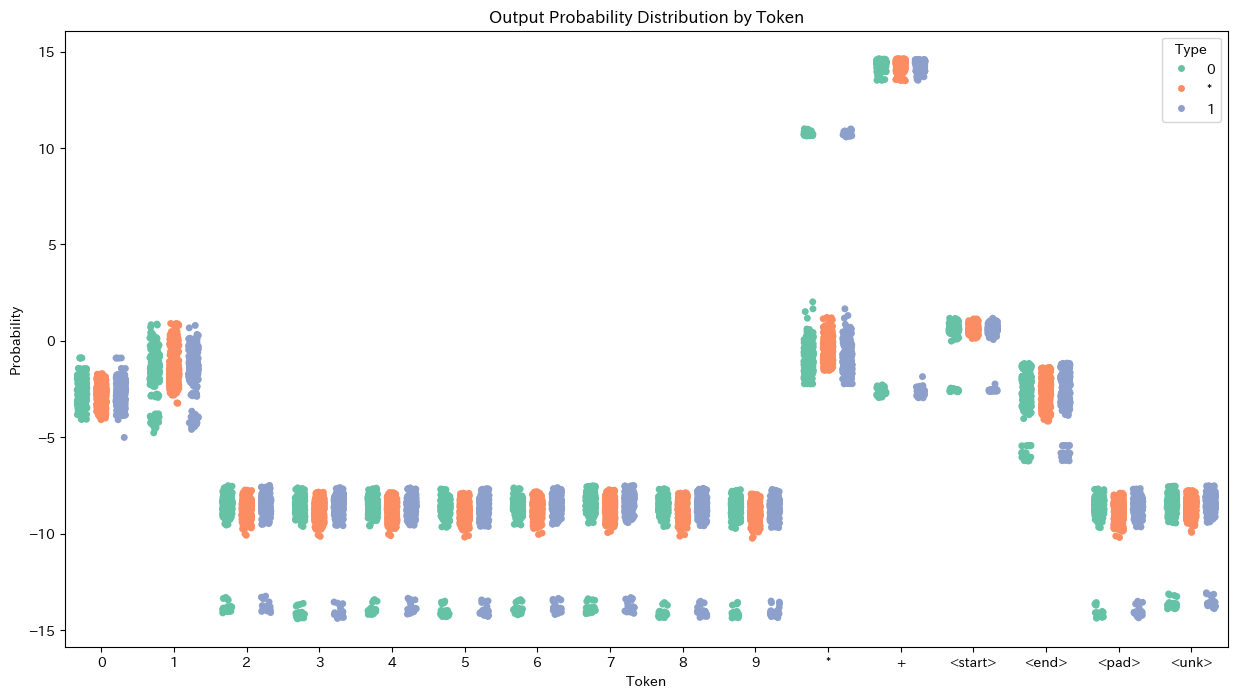

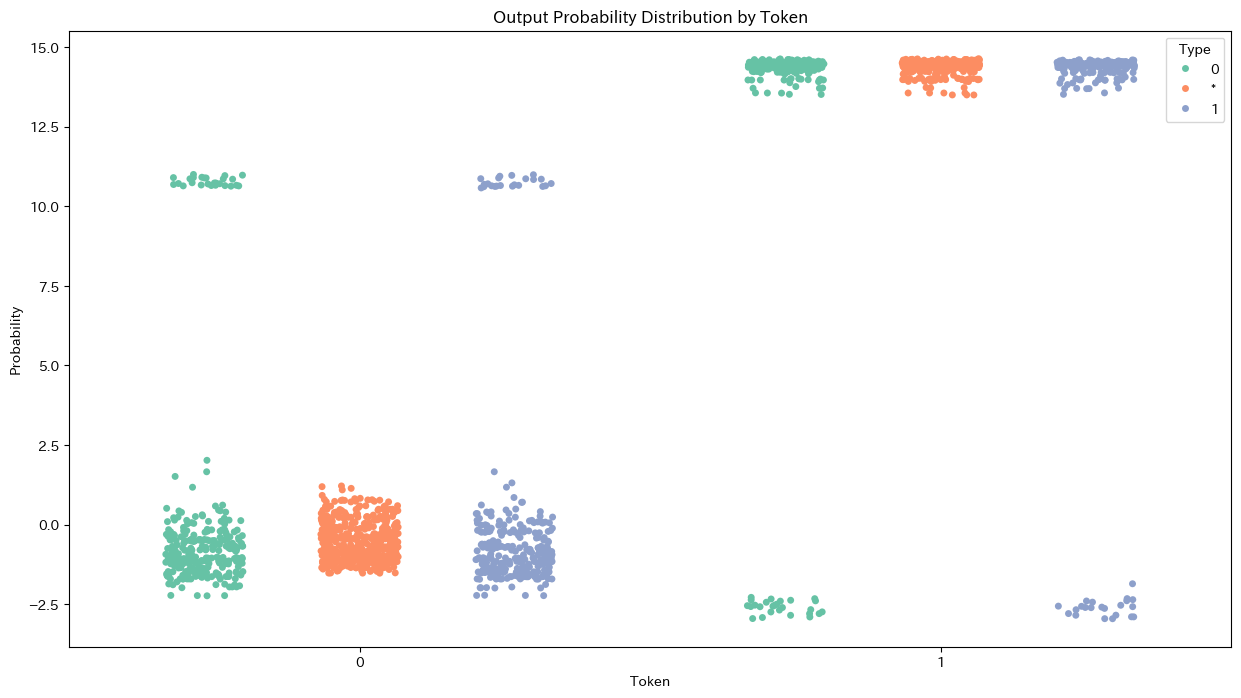

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


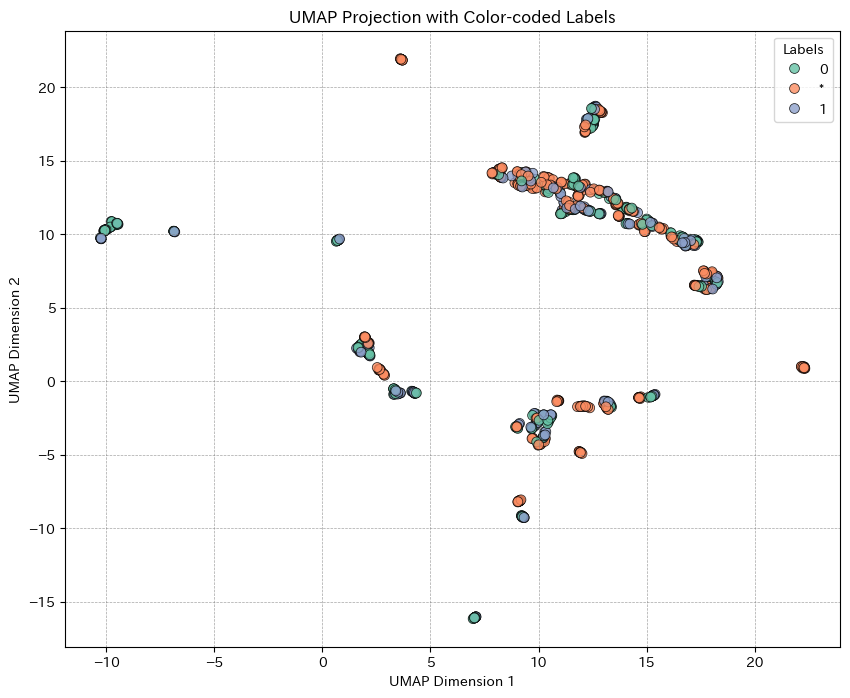

In [33]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt = ys
        for _ in range(nth_token):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)


        tgt = model.positional_encoding(model.token_embedding(ys))
        
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)
        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt)
        output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(output.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, nth_token, loaded_model)
print(test_vectors[:5])
plot_stripplot(test_vectors, test_data_answer_token)
plot_stripplot(test_vectors[:, 10:12], test_data_answer_token)   # +*を適切に分離できていることがわかる
plot_umap_with_labels(test_vectors, test_data_answer_token)

#### CA後で分離できているか

(1040, 2, 16)


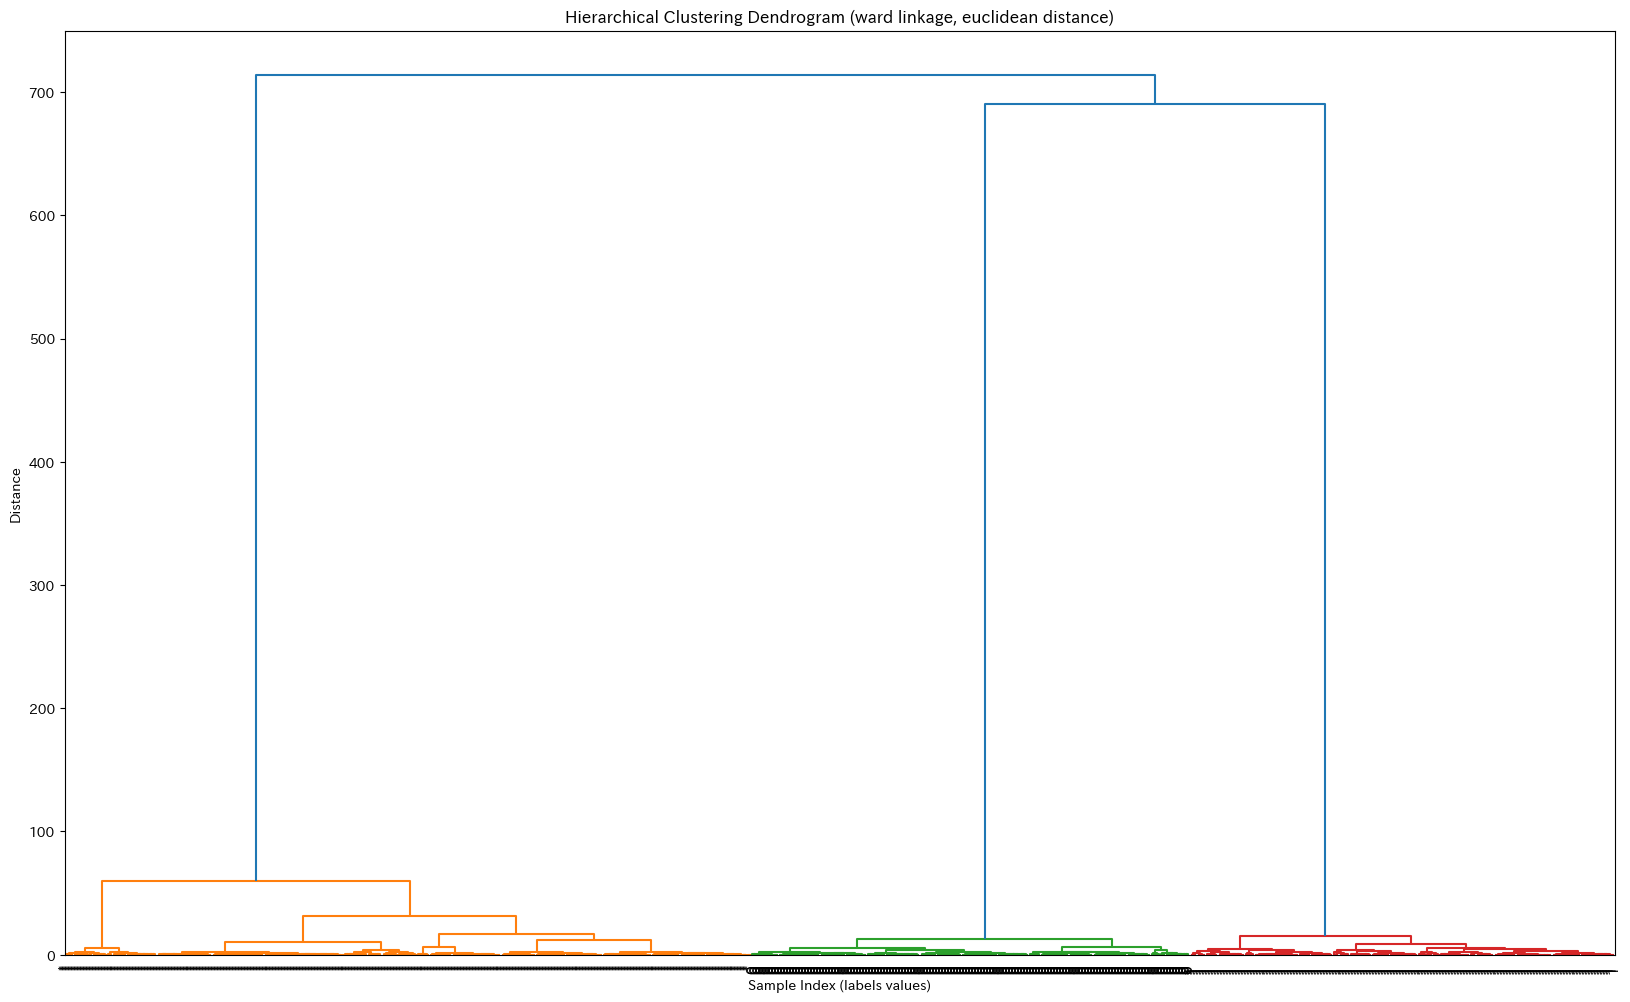

Number of Clusters: 2, Silhouette Score: 0.6589
Number of Clusters: 3, Silhouette Score: 0.9517
Number of Clusters: 4, Silhouette Score: 0.8555
Number of Clusters: 5, Silhouette Score: 0.8133
Number of Clusters: 6, Silhouette Score: 0.8430
Number of Clusters: 7, Silhouette Score: 0.6896
Number of Clusters: 8, Silhouette Score: 0.5486
Number of Clusters: 9, Silhouette Score: 0.5628
Number of Clusters: 10, Silhouette Score: 0.5753
Number of Clusters: 11, Silhouette Score: 0.5635
Number of Clusters: 12, Silhouette Score: 0.5714
Number of Clusters: 13, Silhouette Score: 0.5822
Number of Clusters: 14, Silhouette Score: 0.5913
Number of Clusters: 15, Silhouette Score: 0.5544
Number of Clusters: 16, Silhouette Score: 0.5349
Number of Clusters: 17, Silhouette Score: 0.5322
Number of Clusters: 18, Silhouette Score: 0.5316
Number of Clusters: 19, Silhouette Score: 0.5280
Number of Clusters: 20, Silhouette Score: 0.5319


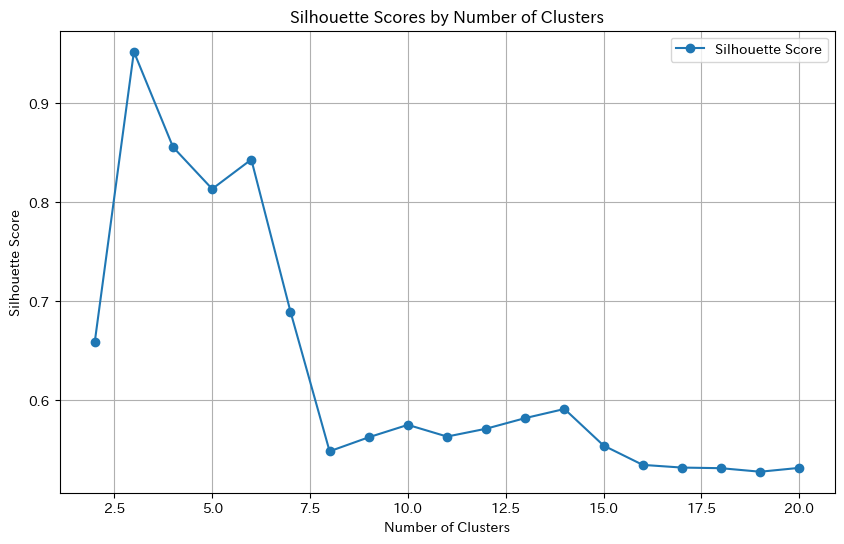

Optimal Number of Clusters: 3
For n_clusters = 2, The average silhouette_score is: 0.6589
Min Silhouette Score: 0.3936375379562378
Max Silhouette Score: 0.9484907984733582


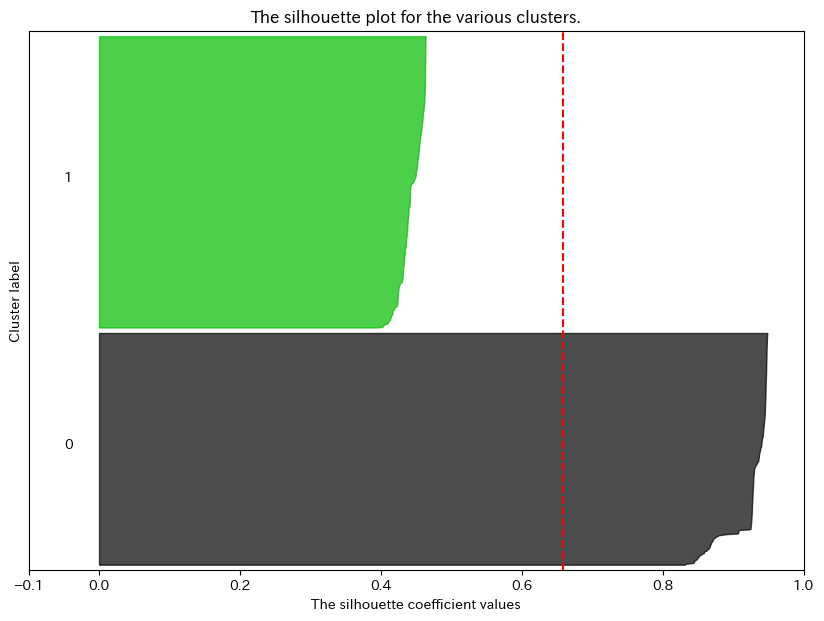

For n_clusters = 5, The average silhouette_score is: 0.8133
Min Silhouette Score: 0.31675952672958374
Max Silhouette Score: 0.9822152853012085


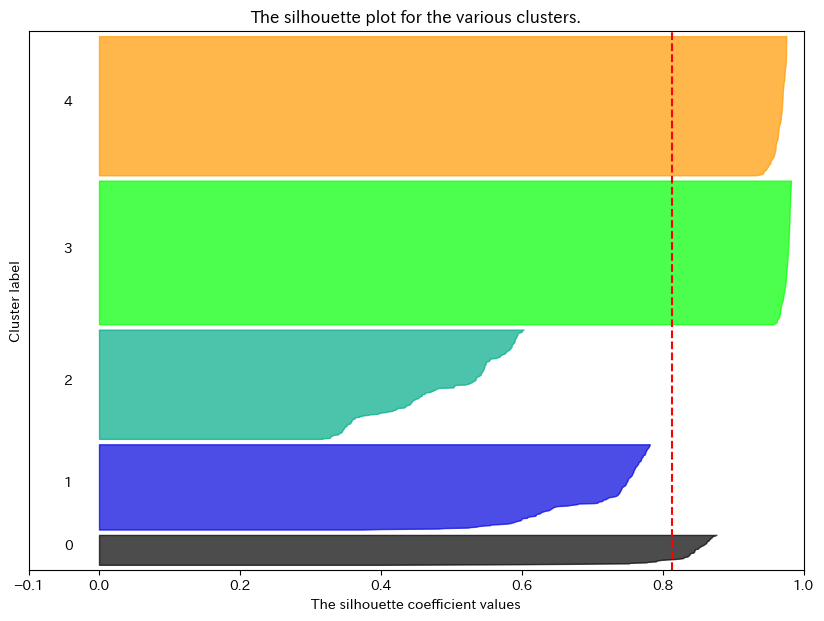

For n_clusters = 3, The average silhouette_score is: 0.9517
Min Silhouette Score: 0.813390851020813
Max Silhouette Score: 0.9826276302337646


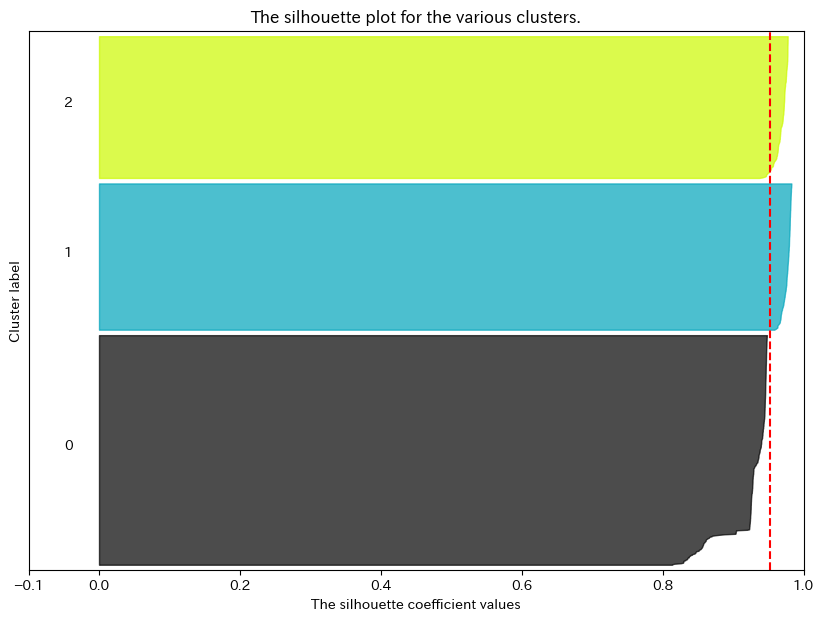

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


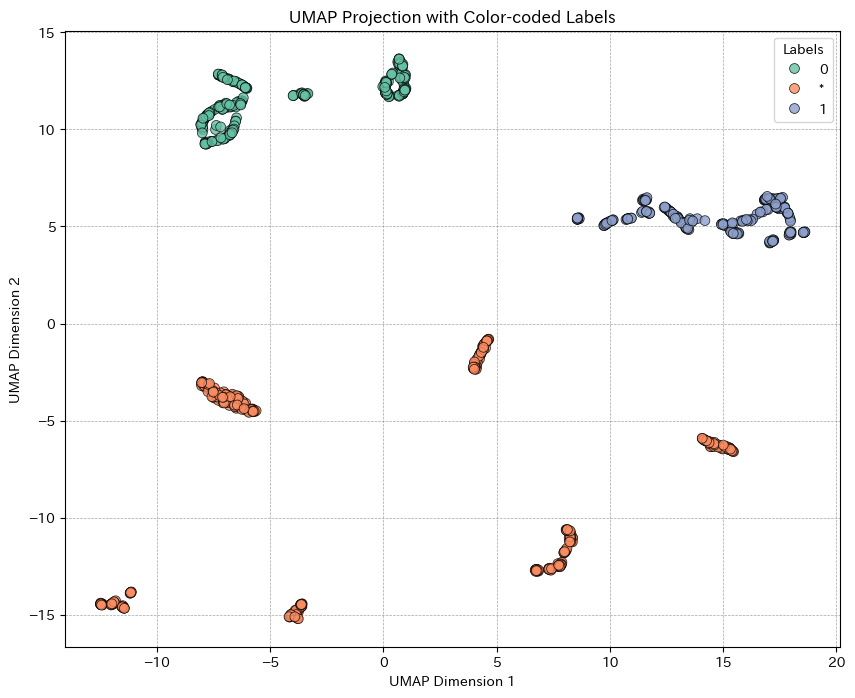

In [34]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt = ys
        for _ in range(nth_token):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)


        tgt = model.positional_encoding(model.token_embedding(tgt))
        
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)
        tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(tgt.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, nth_token, loaded_model)
print(test_vectors.shape)

visualize_hierarchical_clustering_silhouette(test_vectors[:, -1, :], test_data_answer_token)
plot_umap_with_labels(test_vectors[:, -1, :], test_data_answer_token)


#### CAのAttention Mapを表示

In [35]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt = ys
        for _ in range(nth_token):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)

        tgt = model.positional_encoding(model.token_embedding(tgt))
        
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)
        tgt, _, attn_map = model.cross_attn(tgt, memory, embedding_size)
        # tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        attn_map = attn_map.squeeze().detach().cpu().numpy()
        vectors.append(np.pad(attn_map, [(0, 0), (0, 20-attn_map.shape[1])]))
        # vectors.append(np.pad(attn_map, [0, 20-len(attn_map)]))
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, nth_token, loaded_model)


(1040, 2, 20)
0*1*1*1+0
(2, 20)


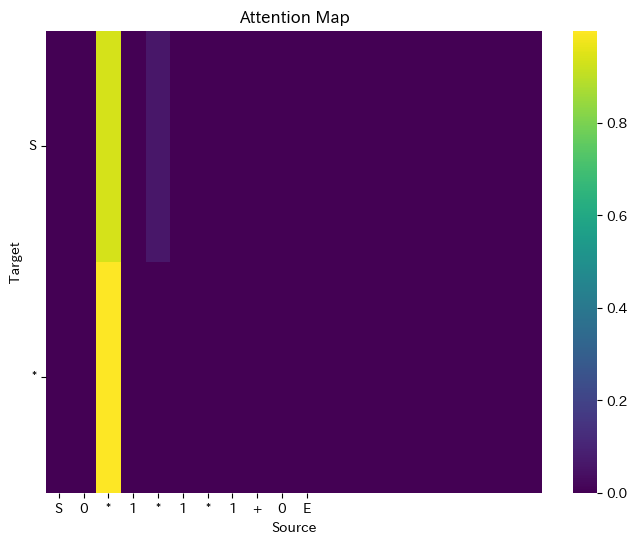

In [36]:

print(test_vectors.shape)
print(test_data_src[3])
print(test_vectors[0].shape)

plot_heatmap(test_vectors[3], ["S"]+list(test_data_src[3])+["E"], list("S"+test_data_answer_token[3][0]), title="Attention Map")
# plot_heatmap(test_vectors[0], ["S"]+list(test_data_src[0])+["E"], list("S"+test_data_answer_token[0][0]), title="Attention Map")

# hierarchical_clustering_with_labels(test_vectors[:, 1, :], test_data_answer_token)
# plot_umap_with_labels(test_vectors[:, 1, :], test_data_answer_token)


#### エンコーディングの結果を表示

(1040, 5, 16)


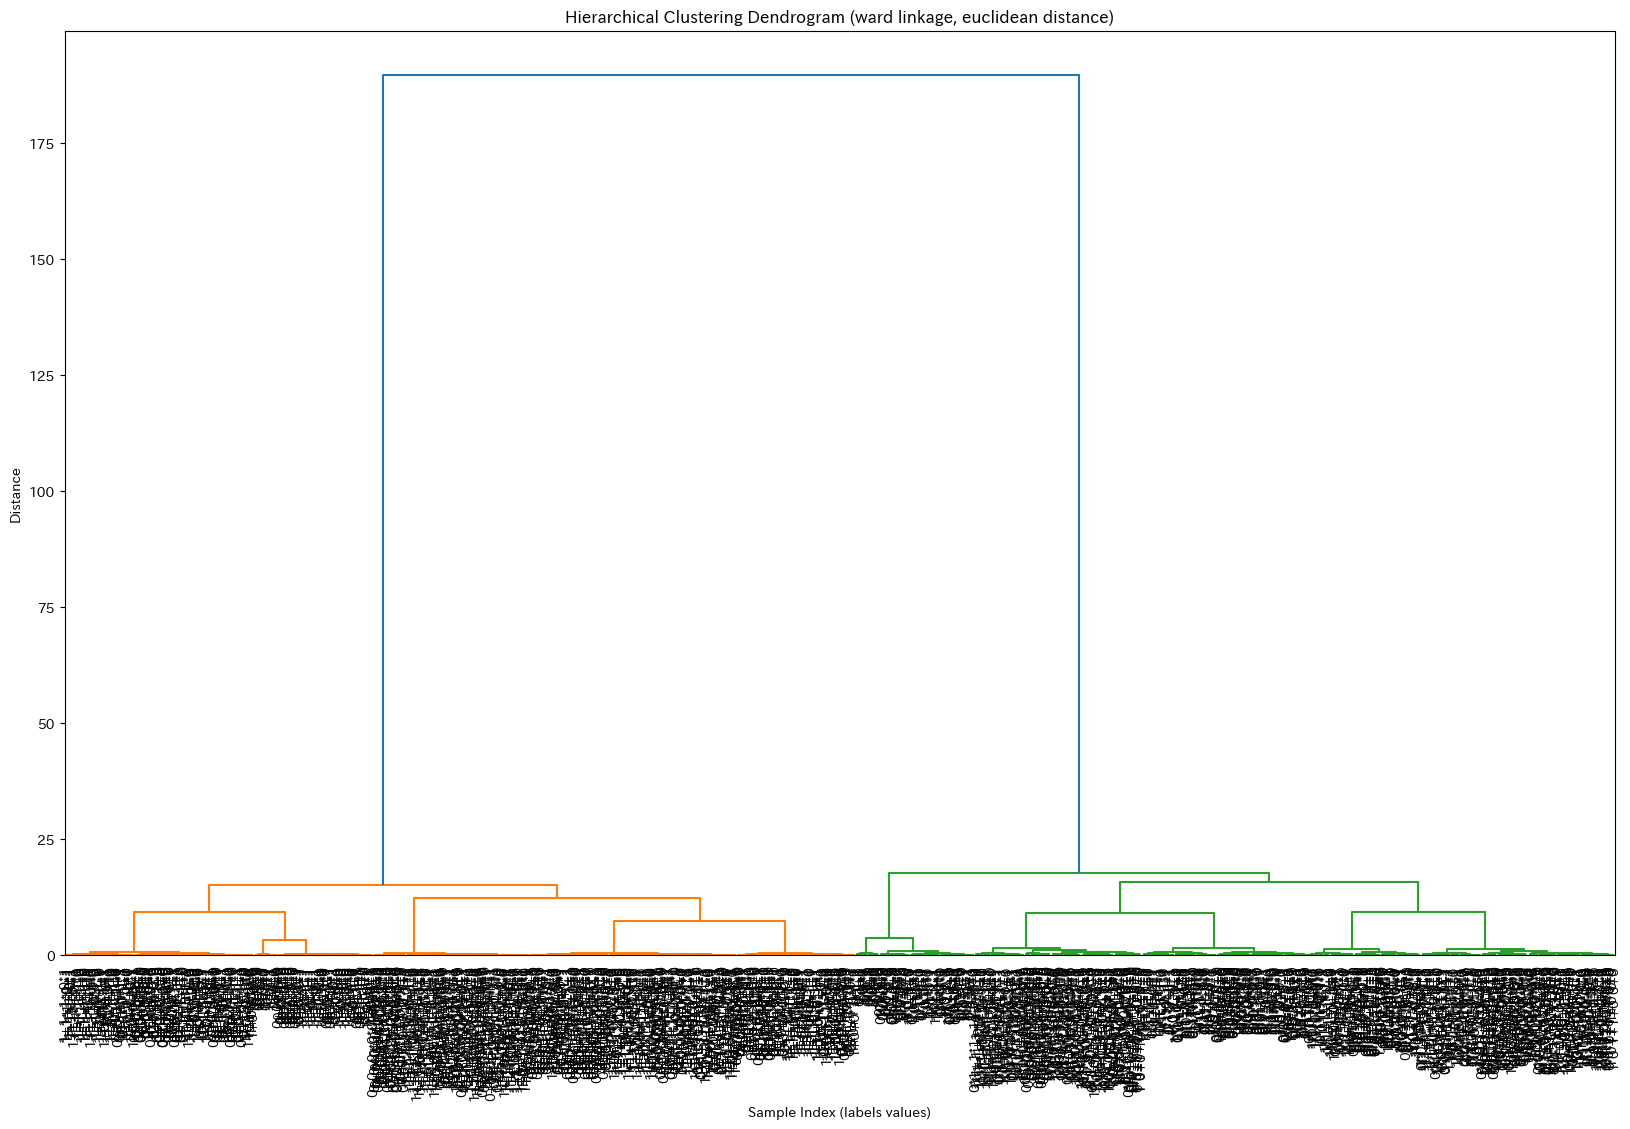

Number of Clusters: 2, Silhouette Score: 0.8832
Number of Clusters: 3, Silhouette Score: 0.7100
Number of Clusters: 4, Silhouette Score: 0.7542
Number of Clusters: 5, Silhouette Score: 0.5536
Number of Clusters: 6, Silhouette Score: 0.6397
Number of Clusters: 7, Silhouette Score: 0.7060
Number of Clusters: 8, Silhouette Score: 0.7460
Number of Clusters: 9, Silhouette Score: 0.8032
Number of Clusters: 10, Silhouette Score: 0.8652
Number of Clusters: 11, Silhouette Score: 0.8694
Number of Clusters: 12, Silhouette Score: 0.8824
Number of Clusters: 13, Silhouette Score: 0.8417
Number of Clusters: 14, Silhouette Score: 0.7947
Number of Clusters: 15, Silhouette Score: 0.7324
Number of Clusters: 16, Silhouette Score: 0.7049
Number of Clusters: 17, Silhouette Score: 0.7051
Number of Clusters: 18, Silhouette Score: 0.6823
Number of Clusters: 19, Silhouette Score: 0.6761
Number of Clusters: 20, Silhouette Score: 0.6286


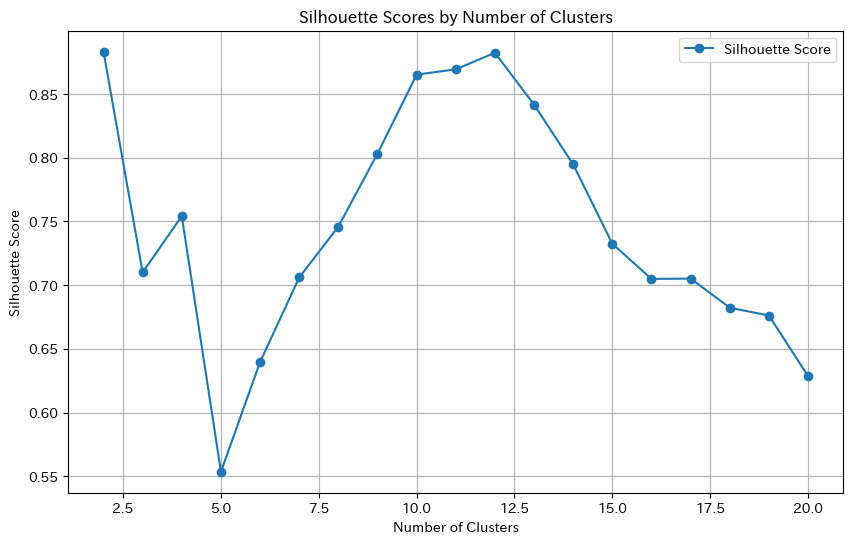

Optimal Number of Clusters: 2
For n_clusters = 2, The average silhouette_score is: 0.8832
Min Silhouette Score: 0.7698426246643066
Max Silhouette Score: 0.9077443480491638


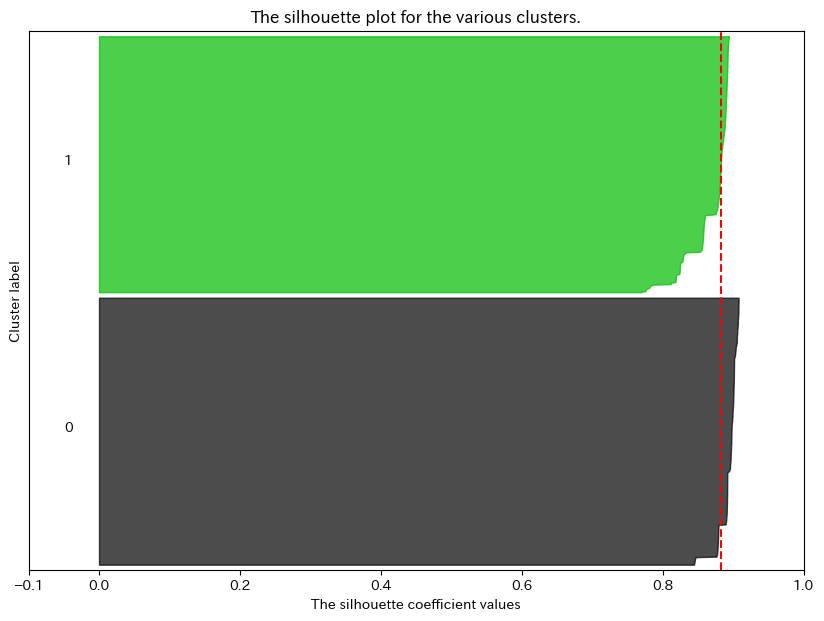

For n_clusters = 5, The average silhouette_score is: 0.5536
Min Silhouette Score: 0.3116281032562256
Max Silhouette Score: 0.8513720035552979


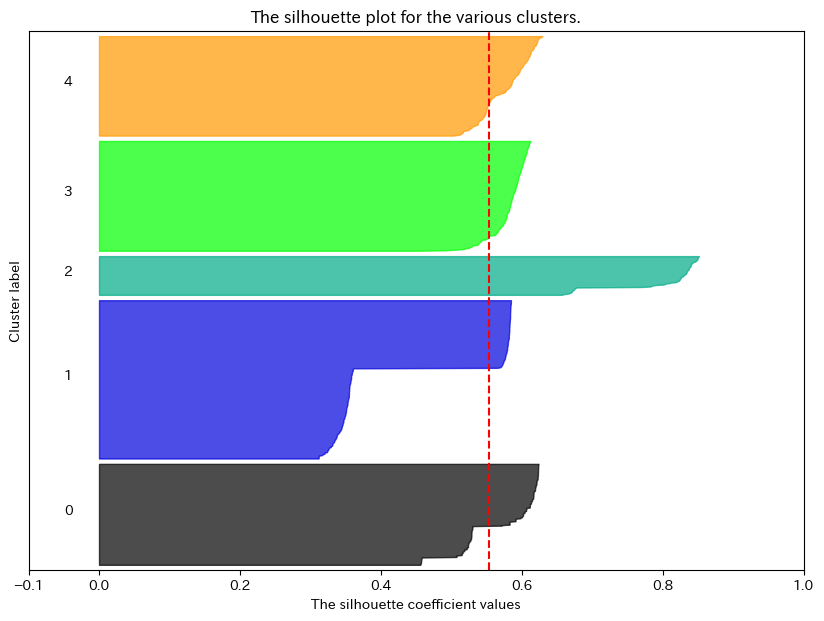

For n_clusters = 2, The average silhouette_score is: 0.8832
Min Silhouette Score: 0.7698426246643066
Max Silhouette Score: 0.9077443480491638


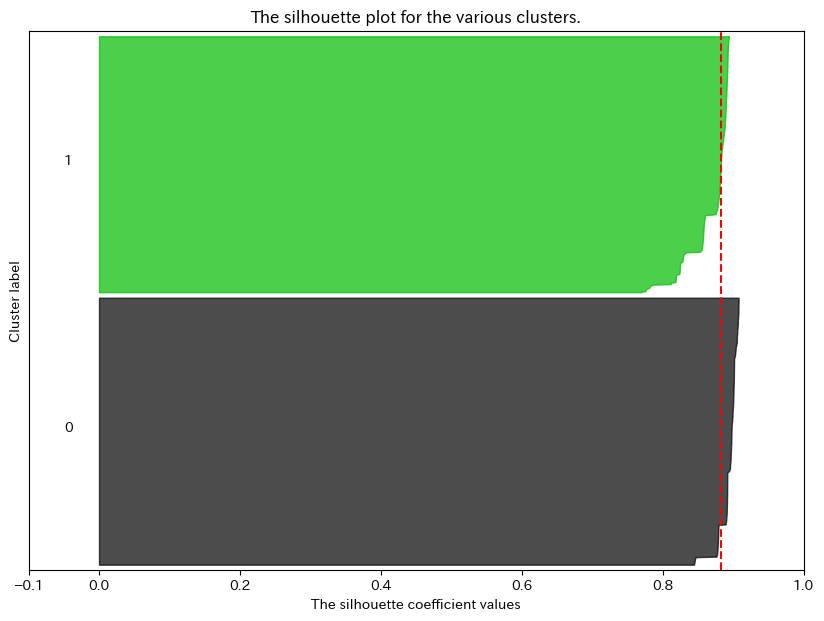

/home/arifuku/ymmtlab/TransformerAnsys/.venv/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


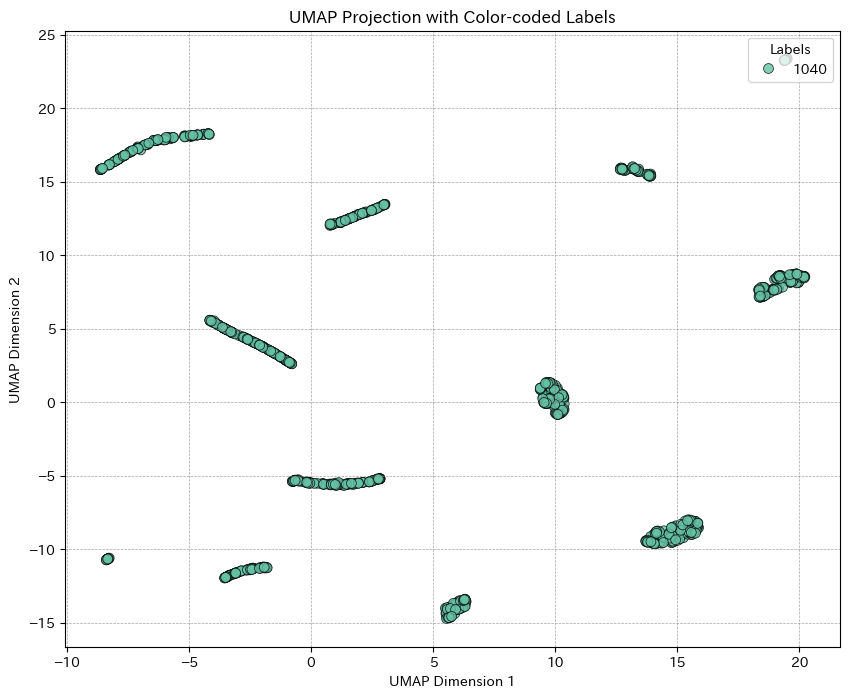

In [37]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        # tgt = ys
        # for _ in range(nth_token):
        #     next_token, _, _ = loaded_model.predict_next_token(src, tgt)
        #     tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)


        # tgt = model.positional_encoding(model.token_embedding(ys))
        
        # tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        # tgt = model.decoder_layer.norm1(tgt)
        # tgt, _, _ = model.cross_attn(tgt, memory, embedding_size)
        # tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(memory.detach().cpu().numpy().squeeze()[:5, :])
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, nth_token, loaded_model)

print(test_vectors.shape)

linkage_matrix, cluster_labels = visualize_hierarchical_clustering_silhouette(test_vectors[:, 2, :], test_data_src)
plot_umap_with_labels(test_vectors[:, 2, :], len(test_data_answer_token))
null = np.array(20*[0])


In [38]:
print(test_data_answer)

['+0+11', '+*1*1*111', '+1+*01*0*11', '+*0*1*110', '+1+*0*00*1*11', '+0*0*11', '+0+*111', '+*11+0+0+1+0*01', '+*11+0+*10+00', '+*1*00+0+0+10', '+1+*10+*10+0+10', '+*011', '+1+1+11', '+0+*010', '+*0*1*111', '+1+*001', '+0+*10+0*01', '+1+0*1*0*10', '*1*1*11', '+*01+1+1+0+*011', '+*00*1*1*1*0*10', '+1+*0*11*10', '+*0*0*0*01+1*00', '+1+1+*1*10*0*10', '+*0*10+01', '+1+*1*1*1*110', '+0+1+1+11', '+0+0+1+0+*111', '+1+1+*00+0*11', '+0+*1*110', '+*01+0+01', '+1+0+0+0*0*0*01', '+*00*00', '+*11+1+*0*101', '+*01+*11*11', '+0+1+10', '+1+1+00', '+*0*1*00+*101', '+*00+10', '+*11*01', '+*01+*0*1*01+01', '+1+1+0+*10+1+01', '+0+1+*01*1*10', '+1+0*1*00', '+1+1+1+*110', '+0+1+1+00', '+0+*1*01+*1*011', '+1+*11+01', '+*00+1+01', '+*01+0+00', '+*11+1+*0*11*00', '+*1*1*1*0*110', '+1+0+1+*01+0*10', '+1+0+0*01', '+*00+1+*001', '+*0*11+1*00', '+0*0*1*10', '+1+0+*0*0*00+10', '+*11+*0*11+01', '+0+*00*0*1*10', '+1+0+0+1+10', '+*11+0+0+1*00', '+1+1+1+11', '+0+0+*11+*101', '+1+1+0+0+1+0+00', '+1+1+1+00', '+*10+*01+*01

In [39]:
display_samples_by_cluster(test_data_src, linkage_matrix, n_clusters=2, num_samples=100)


Cluster 1:
--------------------
0+0+0*1+1
1+1*1*0*0+1+1*0
1+0+1+0+0
0+0+1+1
0+1*0*1
1+1*1*0*0+1
0+1*1+1
0+0+0+0*1*0+1
0+1+0+0+0
1+0*0*0+1*1*1
1+0+0*0+0*1+0+1
0+1*0+1*1
1+0*1+0
1+1+1*1+1+1
0+1+1+0
1+0+1+0
1+1+1+0
1+0*1*0+0
1+1*0*0+1+1
0+0*0+0*1*1+0
0+1+0
0+1+0+0+0*0+0*1
1+1*0+0+0*0*0
1+1+1*0*0
0+0+1*0+1*0*1
0+0*0*1+1*1*1+0
1+1+1*0+1+0*1+0
0+0+0+0*0*0*1
0+0+1*0*1+1+1
1+1+1*0+0*1
0+0+0+0
1+1*1*1+0
1+1*0*0*1*1*0
0+1+0*1*0*0
0+1*1*0+0*1
0+1*0+1
0+0+0+1*1*0*0
0+1+1*0+0
1+0*1+0*0
1+0+0*1+1*1
1+0+0+0*1+1*0+1
1+1*1*0*0*1
1+1*1*1
0+1+1+1+1+1+0*0
0+0+1+1*0+0*1*1
0+1*0+0*0
0+1*0*1*1+1*1*1
0+0*1+0+0
1+1+1*1+0
1+0+0*1+0
0+1+1+1*0+1+1
1+1+1*1*0
1+0+1+0*0+0
0+0+1+0+0
1+0*1*1*1
1+1*0*1
0+1+0*0
0+0*0+0+0
0+1*1*1*1+0*1*1
1+0*0+0*0*0*1
0+1+0*1
1+0+0+0*0+0+0
0+0+1*1+1*0+1
1+0+0*1+1+0*0*0
0+0+0+0*1*0*1+0
0+1*1*1+1+0+1+0
1+0*1*0+1*1*1
0+1+0+0
1+0+0*1
0+1+1+1*0*0+1
0+0+1+0+0+0*0
0+0*1+0*1+0
0+1*1*0
1+1*1+0*1
0+0+0*0+0*1
0+1*1*1*1*0
0+1+1+1+0*1+1
0+1*0*1+1
0+1+1+0*1+0*1*1
1+0*0+1*0*0*1+1
0+1+0+1+0+0+1
1+1+1
1

In [40]:
display_samples_by_cluster(test_data_src, linkage_matrix, n_clusters=4, num_samples=10)


Cluster 1:
--------------------
0+0+0*1+1
1+1*1*0*0+1+1*0
1+0+1+0+0
0+0+1+1
0+1*0*1
1+1*1*0*0+1
0+1*1+1
0+0+0+0*1*0+1
0+1+0+0+0
1+0*0*0+1*1*1

Cluster 2:
--------------------
0*1*0+1
0*1+0
1*1*0+0
1*1+0+0
1*0+0*0
1*1*0+1
0*1+0*1
1*0*0+1
0*0+0*1
1*1*0

Cluster 3:
--------------------
0*0+1*1*1*0*1*0
0*0+1*0+1
0*0*1+0+1
1*0*0*1+1+0+1*0
1*1+1+1+0+0*0+0
1*1*1+1*0+1+1+0
0*0+0*0*1
0*0+1*0*1
0*0+0+0*0+0+0+0
1*1*0*0+0+1+0+1

Cluster 4:
--------------------
0*0+1+0+0+0+0
1*0*0+0*1+1
1*1+0*0+1+0*1
1*1+1*1+0*1+0
0*1*0+0+0*0+1
1*1+0+0+1+1
1*1*1+1*1+0
1*1*1+1+0+1+0
0*1+1+1+0*0+0
0*0*0+1*1+0*1


In [41]:
display_samples_by_cluster(test_data_answer, linkage_matrix, n_clusters=20, num_samples=10)


Cluster 1:
--------------------
+1+*1*101
+1+0*1*01
+1+*11+01
+1+1*1*01
+1+*1*110
+1+0+1*01
+1*1*0*01
+1*1*0*10
+1+1+*010
+1+1*1*10

Cluster 2:
--------------------
+0+*00+00
+1+*0*100
+1*0*0*01
+0+*01+00
+1+0+1+00
+0+1+0+00
+0+0+1*11
+0+*00*00
+1+0+0*00
+0+0+1+10

Cluster 3:
--------------------
+1*11
+1+01
+1+10
+0+00
+1*10
+0*00
+1+00
+0+11
+1*00
+1+11

Cluster 4:
--------------------
+1*1*00
+1+1+10
+1+1+11
+1+*001
+1+1+01
+0+*011
+0+0+01
+0+0+10
+1+1*01
+0+0*00

Cluster 5:
--------------------
+1+*1*00+0+1*01
+1+0*1*1*0*1*01
+0+1+*0*01+*011
+1+0+*10+1+1*11
+1+0+*00+*01+01
+1+*01+*00+0+11
+0+1+1+*01*0*11
+0+1+0+0+*00*01
+1+*1*00*0*1*01
+0+*10+1+*01+01

Cluster 6:
--------------------
+0+0+1*0*1*01
+0+*11+*0*111
+0+*1*0*00*11
+0+*11+0+*100
+0+*1*1*11+10
+1+*01+*00+11
+1+0+0+*00+00
+0+0+*10+1+10
+0+0+*1*00+01
+1+*01+1*1*11

Cluster 7:
--------------------
+0+0*1*0*00
+1+*00*1*01
+0+*0*00*01
+1+0*1*0*10
+0+1+*0*011
+0+*11+1*00
+0+0+1+0*00
+0+1+0+0+01
+0+*00+0*10
+1+*1*00*10

Cluster 

#### Vw\*Memのベクトルを調べる

In [42]:
# 結果の出力を取得
def extract_vectors(data_src, nth_token, model=loaded_model, embedding_size=embedding_size):
    vectors = []
    for src in data_src:
        src = src.view(-1, 1)
        memory = model.positional_encoding(model.token_embedding(src))
        memory, _, _ = model.self_attn_encoder(memory, embedding_size)
        memory = model.encoder_layer.norm1(memory)
        
        tgt = ys
        for _ in range(nth_token):
            next_token, _, _ = loaded_model.predict_next_token(src, tgt)
            tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)


        tgt = model.positional_encoding(model.token_embedding(ys))
        
        tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
        tgt = model.decoder_layer.norm1(tgt)

        # cross-attention
        multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
        multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
        V = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
        # tgt, _, attn_map = model.cross_attn(tgt, memory, embedding_size)
        # tgt = model.decoder_layer.norm2(tgt)
        # output = model.compute_output(tgt.transpose(0, 1)[:, -1])
        vectors.append(V.detach().cpu().numpy().squeeze())
    vectors_array = np.array(vectors)
    return vectors_array

test_vectors = extract_vectors(test_src, nth_token, loaded_model)

print(test_vectors.shape)

linkage_matrix, cluster_labels = visualize_hierarchical_clustering_silhouette(test_vectors[:, 2, :], test_data_answer_token)
plot_umap_with_labels(test_vectors[:, 2, :], cluster_labels)
display_samples_by_cluster(test_data_src, linkage_matrix, n_clusters=4, num_samples=10)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1040,) + inhomogeneous part.

### 調査2: 個別に気になる動作を確認する

#### 初期設定

In [ ]:
text_list = ['0+1+0', '0*1+0']

# 翻訳処理を実行
tokens_src_list = [convert_text_to_indexes(text_list[0], vocab=vocab_src), convert_text_to_indexes(text_list[1], vocab=vocab_src)]
src_list = [torch.LongTensor(tokens_src_list[0]).reshape(len(tokens_src_list[0]), 1).to(device), torch.LongTensor(tokens_src_list[1]).reshape(len(tokens_src_list[1]), 1).to(device)]
ys = torch.ones(1, 1).fill_(START_IDX).type(torch.long).to(device)

tgt = ys
for _ in range(seq_len_tgt):
    next_token, _, _ = loaded_model.predict_next_token(src_list[0], tgt)
    tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)
    if next_token == END_IDX:
        break

print(f"Input: {text_list[0]}")
print(f"Output: {convert_indexes_to_text(tgt.squeeze(1).tolist(), vocab_tgt)}")

tgt = ys
for _ in range(seq_len_tgt):
    next_token, _, _ = loaded_model.predict_next_token(src_list[1], tgt)
    tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)
    if next_token == END_IDX:
        break

print(f"Input: {text_list[1]}")
print(f"Output: {convert_indexes_to_text(tgt.squeeze(1).tolist(), vocab_tgt)}")



#### 最終出力の確認

In [ ]:
def extract_vectors(src, nth_token, model=loaded_model, embedding_size=embedding_size):
    src = src.view(-1, 1)
    memory = model.positional_encoding(model.token_embedding(src))
    memory, _, _ = model.self_attn_encoder(memory, embedding_size)
    memory = model.encoder_layer.norm1(memory)
    
    tgt = ys
    for _ in range(nth_token):
        next_token, _, _ = loaded_model.predict_next_token(src, tgt)
        tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)

    tgt = model.positional_encoding(model.token_embedding(tgt))
    
    tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
    tgt = model.decoder_layer.norm1(tgt)

    # Cross Attention
    multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
    ow, ob = model.decoder_layer.cross_attn.out_proj.weight.data, model.decoder_layer.cross_attn.out_proj.bias.data
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, ow.T) + ob.T
    V = torch.matmul(VW, ow.T) + ob.T
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt_ca = tgt + multi_attn_output
    tgt_ca = model.decoder_layer.norm2(tgt_ca)
    output = torch.max(model.compute_output(tgt_ca.transpose(0, 1)[:, -1]), dim=1)[1]
    return output

test_vectors0 = [extract_vectors(src_list[0], i, loaded_model) for i in range(6)]
test_vectors1 = [extract_vectors(src_list[1], i, loaded_model) for i in range(6)]

print(test_vectors0)
print(test_vectors1)

#### 各段階のベクトルを確認

In [ ]:
def extract_vectors(src, nth_token, model=loaded_model, embedding_size=embedding_size):
    src = src.view(-1, 1)
    memory = model.positional_encoding(model.token_embedding(src))
    memory, _, _ = model.self_attn_encoder(memory, embedding_size)
    memory = model.encoder_layer.norm1(memory)
    
    tgt = ys
    for _ in range(nth_token):
        next_token, _, _ = loaded_model.predict_next_token(src, tgt)
        tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=0)

    tgt = model.positional_encoding(model.token_embedding(tgt))
    
    tgt, _, _ = model.self_attn_decoder(tgt, embedding_size)
    tgt = model.decoder_layer.norm1(tgt)

    # Cross Attention
    multi_attn_wq, multi_attn_wk, multi_attn_wv = model.decoder_layer.cross_attn.in_proj_weight.data.chunk(3, dim=0)
    multi_attn_bq, multi_attn_bk, multi_attn_bv = model.decoder_layer.cross_attn.in_proj_bias.data.chunk(3, dim=0)
    ow, ob = model.decoder_layer.cross_attn.out_proj.weight.data, model.decoder_layer.cross_attn.out_proj.bias.data
    QW = torch.matmul(tgt.permute(1, 0, 2), multi_attn_wq.T) + multi_attn_bq
    KW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wk.T) + multi_attn_bk
    VW = torch.matmul(memory.permute(1, 0, 2), multi_attn_wv.T) + multi_attn_bv
    multi_attn_weights = F.softmax(torch.bmm(QW, KW.transpose(-2, -1)) / math.sqrt(embedding_size), dim=-1)
    AV = torch.matmul(multi_attn_weights, VW)
    multi_attn_output = torch.matmul(AV, ow.T) + ob.T
    V = torch.matmul(VW, ow.T) + ob.T
    multi_attn_output = multi_attn_output.permute(1, 0, 2)
    tgt_ca = tgt + multi_attn_output
    tgt_ca = model.decoder_layer.norm2(tgt_ca)
    output = model.compute_output(tgt_ca.transpose(0, 1)[:, -1])
    max = torch.max(output, dim=1)[1]

    tgt = tgt.detach().cpu().numpy().squeeze()
    V = V.detach().cpu().numpy().squeeze()
    multi_attn_output = multi_attn_output.detach().cpu().numpy().squeeze()
    tgt_ca = tgt_ca.detach().cpu().numpy().squeeze()
    output = output.detach().cpu().numpy().squeeze()
    max = max.detach().cpu().numpy().squeeze()
    
    return {"tgt_sa": tgt, "v":V, "ca_out": multi_attn_output, "tgtca": tgt_ca, "output": output, "max": max}

test_vectors0 = [extract_vectors(src_list[0], 1, loaded_model) for i in range(6)]
test_vectors1 = [extract_vectors(src_list[1], 1, loaded_model) for i in range(6)]
print(test_vectors0[1])
print(test_vectors1[1])



In [ ]:
# 長さを確認
import numpy as np

def calculate_vector_norms(vectors):
    vector_norms = {}
    for key, value in vectors.items():
        # 確認: 値が配列かどうかチェック
        if isinstance(value, np.ndarray):
            # ノルムを計算
            vector_norms[key] = np.linalg.norm(value)
        else:
            vector_norms[key] = None  # 配列以外の場合はスキップ
    return vector_norms

# test_vectorsの各ベクトルのノルムを計算
vector_norms = calculate_vector_norms(test_vectors0[1])

# 結果を表示
for key, norm in vector_norms.items():
    print(f"{key}: {norm}")


In [ ]:

# test_vectorsの各ベクトルのノルムを計算
vector_norms = calculate_vector_norms(test_vectors1[1])

# 結果を表示
for key, norm in vector_norms.items():
    print(f"{key}: {norm}")

In [ ]:
# それぞれのベクトルの類似度を計算

def calculate_vector_norms(vectors):
    vector_norms = {}
    emb = loaded_model.token_embedding.embedding.weight.transpose(0,1).detach().cpu().numpy()
    for key, value in vectors.items():
        # 確認: 値が配列かどうかチェック
        if isinstance(value, np.ndarray):
            # ノルムを計算
            vector_norms[key] = np.dot(value, emb)
        else:
            vector_norms[key] = None  # 配列以外の場合はスキップ
    return vector_norms

vector_norms = calculate_vector_norms(test_vectors0[1])
for key, norm in vector_norms.items():
    print(f"{key}: {norm}")

In [ ]:
vector_norms = calculate_vector_norms(test_vectors1[1])
for key, norm in vector_norms.items():
    print(f"{key}: {norm}")

# margin